# Examples of plots and calculations using the tmm and colorpy package

This example uses tmm and colorpy package to calculate the surface of stacked layers.

Note that ```tmm``` and ```colorpy``` packages are slightly altered from their original version. To successfully run this script, you have to download them from the following github repo:

- tmm: https://github.com/kanhua/tmm
- colorpy: https://github.com/kanhua/ColorPy

## Imports

In [4]:
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function, absolute_import

from pypvcell.tmm_core import (coh_tmm, unpolarized_RT, ellips,
                       position_resolved, find_in_structure_with_inf)

from numpy import pi, linspace, inf, array
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from pypvcell.transfer_matrix_optics import get_ntotal_fn
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set up

In [5]:
try:
    import colorpy.illuminants
    import colorpy.colormodels
    import colorpy.plots
    from tmm import color
    colors_were_imported = True
except ImportError:
    # without colorpy, you can't run sample5(), but everything else is fine.
    colors_were_imported = False


# "5 * degree" is 5 degrees expressed in radians
# "1.2 / degree" is 1.2 radians expressed in degrees
degree = pi/180

In [6]:
if not colors_were_imported:
    print('Colorpy was not detected (or perhaps an error occurred when',
          'loading it). You cannot do color calculations, sorry!',
          'http://pypi.python.org/pypi/colorpy')
else:
    print("Colorpy is successfully installed.")

Colorpy is successfully installed.


# Color calculations

Color calculations: What color is a air / thin SiO2 / Si wafer?

air / 300nm SiO2 / Si --- rgb = [ 0.06686505  0.16499302  0.43846789] , xyY = [0.21595883094398391, 0.2135628007669389, 0.16386997003707909]
Saving plot temp_plot.png
Saving plot temp_plot.png
CPU times: user 2.72 s, sys: 83.3 ms, total: 2.8 s
Wall time: 2.81 s


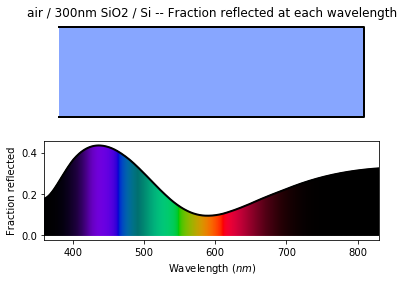

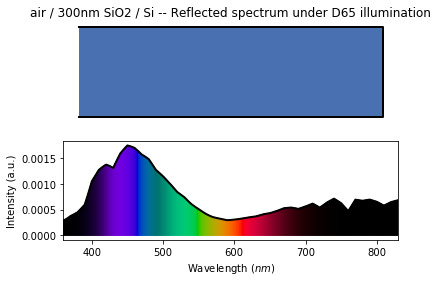

In [7]:
%%time
# Crystalline silicon refractive index. Data from Palik via
# http://refractiveindex.info, I haven't checked it, but this is just for
# demonstration purposes anyway.
Si_n_fn = get_ntotal_fn('a_Si')
# SiO2 refractive index (approximate): 1.46 regardless of wavelength
SiO2_n_fn = get_ntotal_fn('SiO2_2')
# air refractive index
air_n_fn = lambda wavelength : 1

n_fn_list = [air_n_fn, SiO2_n_fn, Si_n_fn]
th_0 = 0

# Print the colors, and show plots, for the special case of 300nm-thick SiO2
d_list = [inf, 300, inf]
reflectances = color.calc_reflectances(n_fn_list, d_list, th_0)
illuminant = colorpy.illuminants.get_illuminant_D65()
spectrum = color.calc_spectrum(reflectances, illuminant)
color_dict = color.calc_color(spectrum)
print('air / 300nm SiO2 / Si --- rgb =', color_dict['rgb'], ', xyY =', color_dict['xyY'])
plt.figure()
color.plot_reflectances(reflectances,
                    title='air / 300nm SiO2 / Si -- '
                          'Fraction reflected at each wavelength')
plt.figure()
color.plot_spectrum(spectrum,
                    title='air / 300nm SiO2 / Si -- '
                          'Reflected spectrum under D65 illumination')

Making color vs SiO2 thickness graph. Compare to (for example)
http://www.htelabs.com/appnotes/sio2_color_chart_thermal_silicon_dioxide.htm


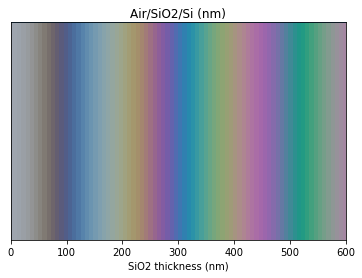

In [8]:
# Calculate irgb color (i.e. gamma-corrected sRGB display color rounded to
# integers 0-255) versus thickness of SiO2
max_SiO2_thickness = 600
SiO2_thickness_list = linspace(0,max_SiO2_thickness,num=80)
irgb_list = []
for SiO2_d in SiO2_thickness_list:
    d_list = [inf, SiO2_d, inf]
    reflectances = color.calc_reflectances(n_fn_list, d_list, th_0,pol='s')
    illuminant = colorpy.illuminants.get_illuminant_D65()
    spectrum = color.calc_spectrum(reflectances, illuminant)
    color_dict = color.calc_color(spectrum)
    irgb_list.append(colorpy.colormodels.irgb_string_from_irgb(color_dict['irgb']))

# Plot those colors
print('Making color vs SiO2 thickness graph. Compare to (for example)')
print('http://www.htelabs.com/appnotes/sio2_color_chart_thermal_silicon_dioxide.htm')
colorpy.plots.color_tile_vs_1param_plot(SiO2_thickness_list,irgb_list,
                                        xlabel_name="SiO2 thickness (nm)",
                                       title_name="Air/SiO2/Si (nm)")

## Make two dimension plot

CPU times: user 23.1 s, sys: 176 ms, total: 23.2 s
Wall time: 23.7 s


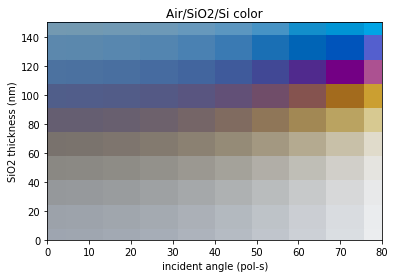

In [9]:
%%time
# Calculate irgb color (i.e. gamma-corrected sRGB display color rounded to
# integers 0-255) versus thickness of SiO2
max_inc_angle = 80
max_d=150
inc_angle = linspace(0,max_inc_angle,num=10)
SiO2_d_list=linspace(0,max_d,num=10)

irgb_list =[]
for i,ang in enumerate(inc_angle):
    for j,SiO2_d in enumerate(SiO2_d_list):
        d_list = [inf, SiO2_d, inf]
        reflectances = color.calc_reflectances(n_fn_list, d_list, ang/180*pi)
        illuminant = colorpy.illuminants.get_illuminant_D65()
        spectrum = color.calc_spectrum(reflectances, illuminant)
        color_dict = color.calc_color(spectrum)
        color_string = colorpy.colormodels.irgb_string_from_irgb(color_dict['irgb'])
        irgb_list.append(color_string)
        
colorpy.plots.color_tile_vs_2param_plot(inc_angle,SiO2_d_list,irgb_list,
                                   xlabel_name="incident angle (pol-s)",
                                  ylabel_name="SiO2 thickness (nm)",
                                  title_name="Air/SiO2/Si color")
plt.savefig("color_tiles_demo.png")